# XGBoost Predictions with various datasets
- target_col = 'rule4_episode'

### Best results with default parameters
### Smote upsampling

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# Python libs
import numpy as np
import pandas as pd
from os.path import isfile, join
import os.path
import re
from google.colab import drive
import sys
import datetime as datetime
import xgboost as xgb
import pickle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import time
import datetime as dt

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:

steps_10_mins = 1
steps_20_mins = 2
steps_30_mins = 3
steps_1_hour = 6
steps_2_hours = 12
steps_12_hours = 12 * steps_1_hour
steps_24_hours = 24 * steps_1_hour

column_year = 'year'
column_month = 'month'
column_hour = 'hour'

MASTER_DATASET = 'model_data_all_features_classified.csv.zip'

In [0]:
data_path = '../gdrive/My Drive/bise_data'

In [0]:
pd.set_option('display.max_columns', None)

In [5]:
drive.mount('/gdrive')
#drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### The dataset is large and problematic to handle, even in Colab
#### MASTER_DATASET should contain the features and the classifications, but the latest versions are cause for a crash while saving to drive
#### At times it is better to collect the classifications and the features separately and merge as needed

##### read the dataset, if latest version was succesfully dumped

In [0]:
file_master = join(data_path, MASTER_DATASET)
df_master = pd.read_csv(file_master, index_col=0)
df_master.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_dir_spread30,BIZ_Wind_dir_spread60,BIZ_Wind_max_EW,BIZ_Wind_max_NS,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed_EW,BIZ_Wind_speed_NS,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_dir_spread30,BUS_Wind_dir_spread60,BUS_Wind_max_EW,BUS_Wind_max_NS,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed_EW,BUS_Wind_speed_NS,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_dir_spread30,GUT_Wind_dir_spread60,GUT_Wind_max_EW,GUT_Wind_max_NS,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed_EW,GUT_Wind_speed_NS,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_dir_spread30,KOP_Wind_dir_spread60,KOP_Wind_max_EW,KOP_Wind_max_NS,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed_EW,KOP_Wind_speed_NS,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_dir_spread30,MOA_Wind_dir_spread60,MOA_Wind_max_EW,MOA_Wind_max_NS,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed_EW,MOA_Wind_speed_NS,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_dir_spread30,MUB_Wind_dir_spread60,MUB_Wind_max_EW,MUB_Wind_max_NS,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed_EW,MUB_Wind_speed_NS,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_dir_spread30,PAY_Wind_dir_spread60,PAY_Wind_max_EW,PAY_Wind_max_NS,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed_EW,PAY_Wind_speed_NS,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_dir_spread30,PUY_Wind_dir_spread60,PUY_Wind_max_EW,PUY_Wind_max_NS,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed_EW,PUY_Wind_speed_NS,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_dir_spread30,REH_Wind_dir_spread60,REH_Wind_max_EW,REH_Wind_max_NS,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed_EW,REH_Wind_speed_NS,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_dir_spre

##### otherwise read classifications an features separately

In [6]:
df_class = pd.read_csv(join(data_path, 'bise_classifications_extended.csv.zip'), index_col=0)
df_class.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class
0,2014-01-01 00:00:00,0,2014,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0
1,2014-01-01 00:10:00,1,2014,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0
2,2014-01-01 00:20:00,2,2014,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0
3,2014-01-01 00:30:00,3,2014,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0
4,2014-01-01 00:40:00,4,2014,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0


In [0]:
def run_xgboost_predictions_no_tuning_DEL(df_train_x, df_train_y, df_test_x, df_test_y, longest_pred_period, dump_dir=None,
                                      **hyperparams):
    """Runs XGBoost with a fixed set of classifier hyperparameters, perfoming data delay to a maximum of 'longest_pred_period'
    steps (corresponding to 10 mins each)"""
    # initialise two empty dictionaries to store the models and scores
    xgboostmodels = {}
    xgboostscores = {}
    xgboostconfmatrixes = {}
    xgboostpredictions = {}
    prediction_period = [i for i in
                         range(1, longest_pred_period + 1)]  # how far into the future to predict (10 minute segments)

    score = -1
    counter = 1
    for prediction in prediction_period:

        reg = xgb.XGBClassifier()
        reg.set_params(**hyperparams)
        X_train = df_train_x[:-prediction]  # everything except the last value
        y_train = df_train_y[prediction:]  # offset by 10mins

        X_test = df_test_x[:-prediction]  # everything except the last value
        y_test = df_test_y[prediction:]  # offset by 10mins

        key = 'xgboost_model_' + str(prediction * 10)

        xgboostmodels[key] = reg.fit(X_train, y_train, verbose=2)  # store the model

        # score = np.mean(ms.cross_val_score(reg, x_train, y_train, scoring='roc_auc', cv=5))

        y_pred = reg.predict(X_test)
        xgboostpredictions[key] = y_pred

        prec_score, rec_score, f_score = get_scores(y_test, y_pred)
        xgboostscores[key] = rec_score  # store the model score

        print(classification_report(y_test, y_pred))
        print(counter, rec_score)
        if prec_score[1] > score:
            if dump_dir:
                file_path = join(dump_dir, 'xgb_no_tuning_' + str(time.time()) + '.dat')
                print(f'Model improved accuracy, saving to {file_path}')
                pickle.dump(reg, open(file_path, "wb"))
            score = prec_score[1]
        counter += 1

        cm = None
        try:
            cm = confusion_matrix(y_test, y_pred)
        except:
            print('Confusion Matrix crash!!!')
            print(type(y_test), type(y_pred))

        xgboostconfmatrixes[key] = cm
    return xgboostmodels, xgboostscores, xgboostconfmatrixes, xgboostpredictions 
  

def train_test_modeling_multiclass(df_train, df_test, features, predicted_value):
    prediction = 2

    # Create the train test data sets
    X_train = df_train[features][:-prediction]  # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:]  # offset by 20mins
    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:]  # offset by 20mins

    parameters = {"scale_pos_weight": range(0, 5),
                  "n_estimators": range(10, 200, 10),
                  "learning_rate": [0.05, 0.1],
                  "max_depth": range(1, 10),
                  "subsample": [0.4, 0.7, 0.9],
                  "colsample_bytree": [0.3, 0.5, 1],
                  "gamma": [0, 1, 5],
                  }
    scoring = {'f1': make_scorer(f1_score, average='weighted')}

    XGB = xgb.XGBClassifier(objective="multi:softprob", num_class=4)
    XGB_base_rand = RandomizedSearchCV(XGB, parameters, cv=3, scoring=scoring, return_train_score=True, n_jobs=-1,
                                       refit='f1')
    XGB_base_rand.fit(X_train, y_train)
    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))


def train_test_modeling(df_train, df_test, features, predicted_value, prediction, scoring, **hyperparams):

    # Create the train test data sets
    X_train = df_train[features][:-prediction]  # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:]  # offset by 20mins
    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:]  # offset by 20mins

    XGB = xgb.XGBClassifier()
    XGB_base_rand = RandomizedSearchCV(XGB, hyperparams, cv=3, scoring=scoring, return_train_score=True, n_jobs=-1)
    XGB_base_rand.fit(X_train, y_train)
    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))
    
    return XGB_base_rand
  
def timer_DEL(start_time=None):
    if not start_time:
        start_time = dt.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((dt.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
def left_join_datasets_DEL(left, right, on='datetime'):
    """
    Performs left join (merge) upon column 'on'.
    At least one of the dataframes should carry the 'on' column
    :param left: dataframe
    :param right: dataframe
    :param on: column upon which the dataframes are merged
    :return: new dataframe
    """
    
    drop_on_from_left = False
    drop_on_from_right = False


    if not(on in left.columns):
        if not(on in right.columns):
            raise Exception('Specified column to join on in neither dataset')
        else:
            left.insert(0, on, right[on])
            drop_on_from_left = True

    if not (on in right.columns):
        right.insert(0, on, left[on])
        drop_on_from_right = True

    df = pd.merge(left, right, on=on)

    if drop_on_from_left:
        left.drop(columns=[on], inplace=True)
    elif drop_on_from_right:
        right.drop(columns=[on], inplace=True)

    return df
  
  
def extract_year_as_column_DEL(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_year] = pd.DatetimeIndex(df[datetime_col]).year
    
def extract_month_as_column_DEL(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_month] = pd.DatetimeIndex(df[datetime_col]).month
    
def extract_hour_as_column_DEL(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_hour] = pd.DatetimeIndex(df[datetime_col]).hour


def print_confusion_matrix_DEL(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig


def run_xgboost_prediction_no_lag_DEL(df_train_x, df_train_y, df_test_x, df_test_y, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification"""

    reg = xgb.XGBClassifier()
    reg.set_params(**hyperparams)
    
    X_train = df_train_x
    y_train = df_train_y
    
    X_test = df_test_x
    y_test = df_test_y

    reg.fit(X_train, y_train, verbose=2)

    y_pred = reg.predict(X_test)

    prec_score, rec_score, f_score = get_scores(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    if dump_dir:
        file_path = join(dump_dir, 'xgb_no_tuning_single_pred' + str(time.time()) + '.dat')
        print(f'saving to {file_path}')
        pickle.dump(reg, open(file_path, "wb"))

    cm = None

    try:
        cm = confusion_matrix(y_test, y_pred), y_pred
    except:
        print('Confusion Matrix crash!!!')
        print(type(y_test), type(y_pred))


    return reg, prec_score, rec_score, f_score, cm 

In [0]:
def train_test_modeling_no_score(df_train, df_test, features, predicted_value, prediction, **hyperparams):

    # Create the train test data sets
    X_train = df_train[features][:-prediction]  # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:]  # offset by 20mins
    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:]  # offset by 20mins

    XGB = xgb.XGBClassifier()
    XGB_base_rand = RandomizedSearchCV(XGB, hyperparams, cv=3, return_train_score=True, n_jobs=-1)
    XGB_base_rand.fit(X_train, y_train)
    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))
    
    return XGB_base_rand

In [0]:
def predict_with_confusion_matrix(**hyperparams):
  
  XGB = xgb.XGBClassifier()#**XGB_base_rand.best_params_, objective = 'binary:logistic', gpu_id=0, tree_method = "gpu_hist"
  XGB.set_params(**hyperparams)
  XGB.fit(X_train, y_train)
  #XGB.fit(X_train, y_train, sample_weight = df_train['rule4_end_weights'], sample_weight_eval_set=df_test['rule4_end_weights'])
  y_pred = XGB.predict(X_test)


  #################    
  print(classification_report(y_test, y_pred))
  confusion = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(9,9))
  sn.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');



### Drop first 6 rows as they have NaNs, then generate train and test

In [0]:
df_master = df_master[6:]
df_base_train = df_master[df_master.year < 2018]
df_base_test = df_master[df_master.year >= 2018]

print(df_base_train.shape, df_base_test.shape)

(210378, 832) (52417, 832)


In [0]:
df_base_valid = df_base_train.iloc[140000:] 
df_base_train = df_base_train.iloc[:140000]

print(df_base_train.shape, df_base_valid.shape, df_base_test.shape)

(140000, 832) (70378, 832) (52417, 832)


In [0]:
df_master.isna().sum()[df_master.isna().sum() > 0]

Series([], dtype: int64)

## Run some predictitions on a growing feature set for bise event (rule 4)

In [0]:
target_col = 'rule4_episode'

In [0]:
val_count = df_base_train.rule4_episode.value_counts()
neg_pos_ratio = val_count[0] / val_count[1]
print(val_count, neg_pos_ratio)

0    203910
1      6468
Name: rule4_episode, dtype: int64 31.525974025974026


## Tuning parameters
Best results were obtained with the default parameters of XGBoost

In [0]:
hyperparams = {"scale_pos_weight": [10, neg_pos_ratio, 50],
                  "n_estimators": range(10, 200, 10),
                  "eta": [0.02, 0.05, 0.1],
                  "max_depth": range(1, 10),
                  "subsample": [0.4, 0.7, 0.9],
                  "colsample_bytree": [0.3, 0.5, 1],
                  "gamma": [0, 1, 5],
                  'gpu_id': [0], 
                  'tree_method': ["gpu_hist"],
                  'objective': ['binary:logistic']
                  }

### Simple unique pressure difference

In [0]:
feats = ['QNH_GUT_minus_PAY']

In [0]:
df_base_train[feats]

start = timer()

XGB_base_rand =  train_test_modeling_no_score(df_base_train, df_base_test, feats, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)

{'tree_method': 'gpu_hist', 'subsample': 0.9, 'scale_pos_weight': 10, 'objective': 'binary:logistic', 'n_estimators': 70, 'max_depth': 8, 'gpu_id': 0, 'gamma': 5, 'eta': 0.02, 'colsample_bytree': 0.3}
0.9248773624367799
Test score: 0.8976247257464466

 Time taken: 0 hours 0 minutes and 29.87 seconds.


In [0]:
XGB_base_rand.best_params_

{'colsample_bytree': 0.3,
 'eta': 0.02,
 'gamma': 5,
 'gpu_id': 0,
 'max_depth': 8,
 'n_estimators': 70,
 'objective': 'binary:logistic',
 'scale_pos_weight': 10,
 'subsample': 0.9,
 'tree_method': 'gpu_hist'}

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     49780
           1       0.68      0.19      0.30      2635

    accuracy                           0.95     52415
   macro avg       0.82      0.59      0.64     52415
weighted avg       0.94      0.95      0.94     52415



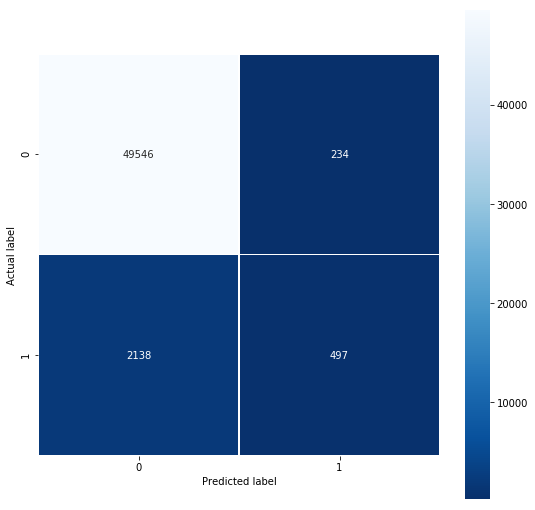

In [0]:
X_train = df_base_train[feats][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]  # offset by 20mins

predict_with_confusion_matrix(**{})

In [0]:
prediction = const

# Create the train test data sets




start = timer()

predict_with_confusion_matrix(**XGB_base_rand.best_params_)

timer(start)



NameError: ignored

### Pressure differences excluded engineered differences

In [0]:
feats_simple_pressure_diff = [c for c in df_base_test.columns if re.search('^QNH_\.*', c) and not(re.search('delta', c))]
#feats_simple_pressure_diff

In [0]:
start = timer()

xgb_rand_simple_pressure_delta =  train_test_modeling_no_score(df_base_train, df_base_test, feats_simple_pressure_diff, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'tree_method': 'gpu_hist', 'subsample': 0.4, 'scale_pos_weight': 10, 'objective': 'binary:logistic', 'n_estimators': 60, 'max_depth': 9, 'gpu_id': 0, 'gamma': 0, 'eta': 0.1, 'colsample_bytree': 1}
0.9616020838878959
Test score: 0.944328913478966

 Time taken: 0 hours 0 minutes and 43.7 seconds.


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     49780
           1       0.72      0.32      0.44      2635

    accuracy                           0.96     52415
   macro avg       0.84      0.66      0.71     52415
weighted avg       0.95      0.96      0.95     52415



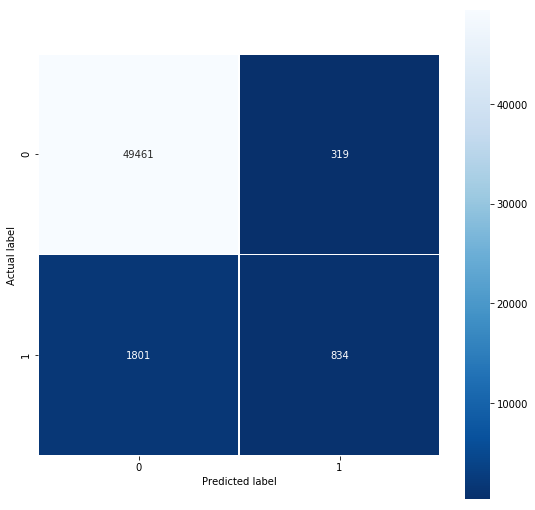

In [0]:
X_train = df_base_train[feats_simple_pressure_diff][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_simple_pressure_diff][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]

predict_with_confusion_matrix(**{})

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     49780
           1       0.45      0.53      0.49      2635

    accuracy                           0.94     52415
   macro avg       0.71      0.75      0.73     52415
weighted avg       0.95      0.94      0.95     52415


 Time taken: 0 hours 0 minutes and 2.75 seconds.


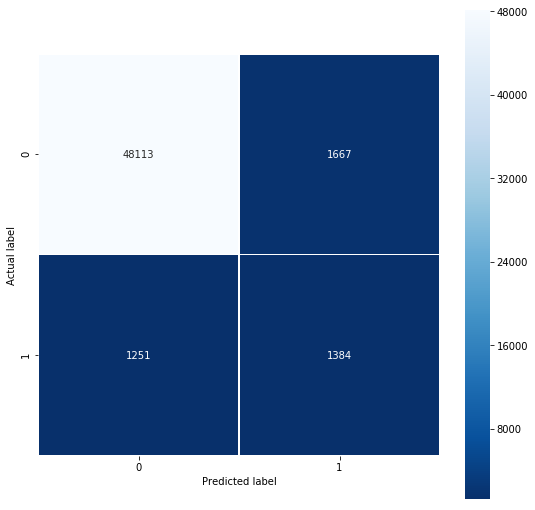

In [0]:
start = timer()


predict_with_confusion_matrix(**xgb_rand_simple_pressure_delta.best_params_)

timer(start)

In [0]:
X_train = df_base_train[feats_simple_pressure_diff][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_simple_pressure_diff][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]


reg, prec_score, rec_score, f_score, cm = run_xgboost_prediction(df_base_train[feats_simple_pressure_diff], df_base_train[target_col], df_base_test[feats_simple_pressure_diff], df_base_test[target_col], pred_period=2, dump_dir=None, **xgb_rand_simple_pressure_delta.best_params_)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     49780
           1       0.45      0.53      0.49      2635

    accuracy                           0.94     52415
   macro avg       0.71      0.75      0.73     52415
weighted avg       0.95      0.94      0.95     52415



In [0]:
cm

(array([[48113,  1667],
        [ 1251,  1384]]), array([0, 0, 0, ..., 0, 0, 0]))

### All pressure differences including engineered ones

In [0]:
feats_all_press_diffs = [c for c in df_base_train.columns if re.search('^QNH.*', c)]#
feats_all_press_diffs
start = timer()

xgb_rand_all_pressure_delta =  train_test_modeling_no_score(df_base_train, df_base_test, feats_all_press_diffs, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'tree_method': 'gpu_hist', 'subsample': 0.9, 'scale_pos_weight': 10, 'objective': 'binary:logistic', 'n_estimators': 100, 'max_depth': 7, 'gpu_id': 0, 'gamma': 5, 'eta': 0.02, 'colsample_bytree': 0.5}
0.9649056926645625
Test score: 0.9475531813412191

 Time taken: 0 hours 2 minutes and 10.56 seconds.


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     49780
           1       0.73      0.32      0.45      2635

    accuracy                           0.96     52415
   macro avg       0.85      0.66      0.71     52415
weighted avg       0.95      0.96      0.95     52415



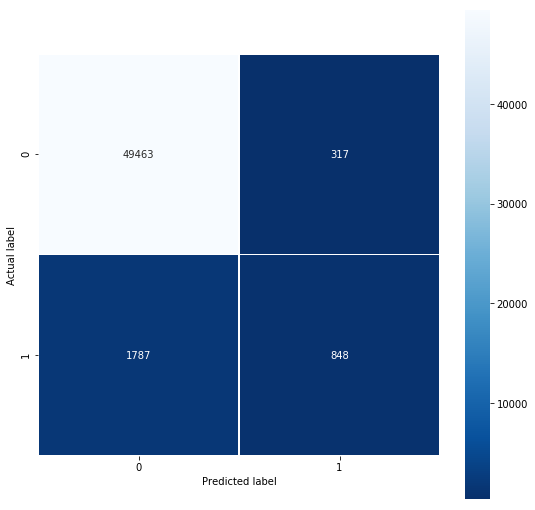

In [0]:
X_train = df_base_train[feats_all_press_diffs][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_all_press_diffs][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]

predict_with_confusion_matrix(**{})

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     49780
           1       0.59      0.44      0.50      2635

    accuracy                           0.96     52415
   macro avg       0.78      0.71      0.74     52415
weighted avg       0.95      0.96      0.95     52415


 Time taken: 0 hours 0 minutes and 11.29 seconds.


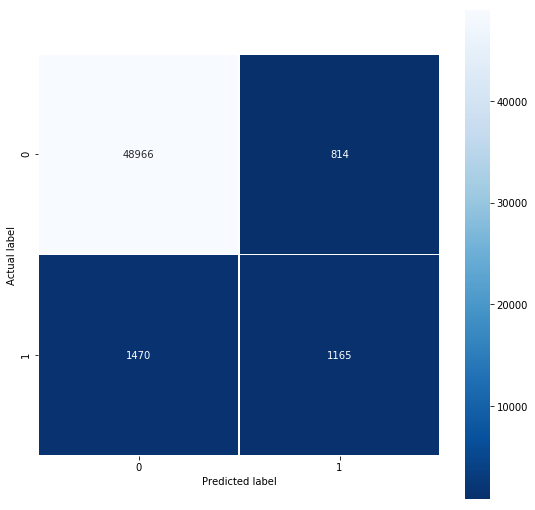

In [0]:
start = timer()



predict_with_confusion_matrix(**xgb_rand_all_pressure_delta.best_params_)

timer(start)

### All Kloten + all pressure differeces, inclusve engineered ones

In [0]:
feats_all_press_diffs_klo = [c for c in df_base_train.columns if re.search('^KLO*', c) and not(c in feats_all_press_diffs)]#
feats_all_press_diffs_klo +=  feats_all_press_diffs
#feats_all_press_diffs_klo

In [0]:

start = timer()

xgb_rand_all_pressure_delta_klo =  train_test_modeling_no_score(df_base_train, df_base_test, feats_all_press_diffs_klo, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'tree_method': 'gpu_hist', 'subsample': 0.9, 'scale_pos_weight': 31.525974025974026, 'objective': 'binary:logistic', 'n_estimators': 100, 'max_depth': 9, 'gpu_id': 0, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.5}
0.9864718408943987
Test score: 0.9773347324239244

 Time taken: 0 hours 2 minutes and 7.55 seconds.


In [0]:
best = xgb_rand_all_pressure_delta_klo.best_params_
best

{'colsample_bytree': 0.5,
 'eta': 0.1,
 'gamma': 5,
 'gpu_id': 0,
 'max_depth': 9,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'scale_pos_weight': 31.525974025974026,
 'subsample': 0.9,
 'tree_method': 'gpu_hist'}

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.87      0.77      0.82      2635

    accuracy                           0.98     52415
   macro avg       0.93      0.88      0.90     52415
weighted avg       0.98      0.98      0.98     52415



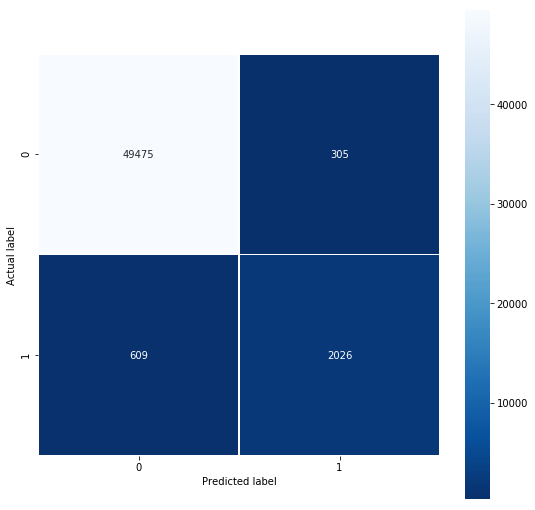

In [0]:
X_train = df_base_train[feats_all_press_diffs_klo][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_all_press_diffs_klo][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]

predict_with_confusion_matrix(**{})

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     49780
           1       0.49      0.57      0.53      2635

    accuracy                           0.95     52415
   macro avg       0.73      0.77      0.75     52415
weighted avg       0.95      0.95      0.95     52415


 Time taken: 0 hours 0 minutes and 9.01 seconds.


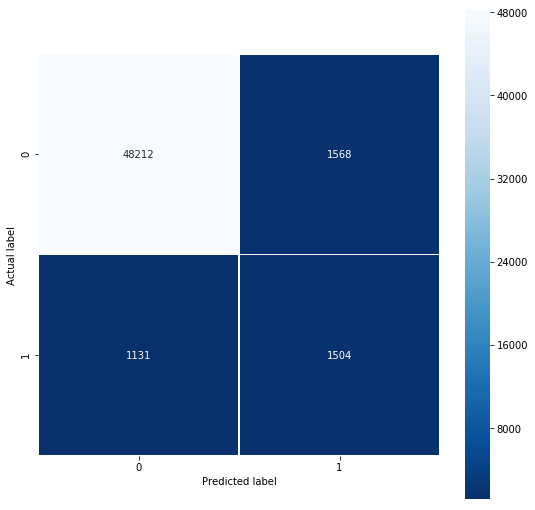

In [0]:
start = timer()



predict_with_confusion_matrix(**best)

timer(start)

### All Kloten features inclusive of enginereed features

In [0]:
feats_klo = [c for c in df_base_test.columns if re.search('^KLO', c)]
#feats_klo

In [0]:
start = timer()

xgb_rand_only_klo =  train_test_modeling_no_score(df_base_train, df_base_test, feats_klo, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'tree_method': 'gpu_hist', 'subsample': 0.9, 'scale_pos_weight': 10, 'objective': 'binary:logistic', 'n_estimators': 110, 'max_depth': 8, 'gpu_id': 0, 'gamma': 0, 'eta': 0.1, 'colsample_bytree': 0.5}
0.9860202684716888
Test score: 0.9763426500047696

 Time taken: 0 hours 0 minutes and 33.05 seconds.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.87      0.78      0.82      2635

    accuracy                           0.98     52415
   macro avg       0.93      0.89      0.91     52415
weighted avg       0.98      0.98      0.98     52415



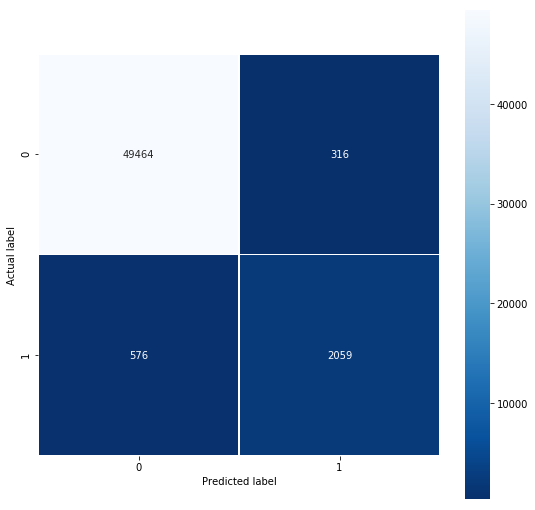

In [0]:
X_train = df_base_train[feats_klo][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_klo][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]

predict_with_confusion_matrix(**{})

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     49780
           1       0.72      0.88      0.79      2635

    accuracy                           0.98     52415
   macro avg       0.85      0.93      0.89     52415
weighted avg       0.98      0.98      0.98     52415


 Time taken: 0 hours 0 minutes and 1.71 seconds.


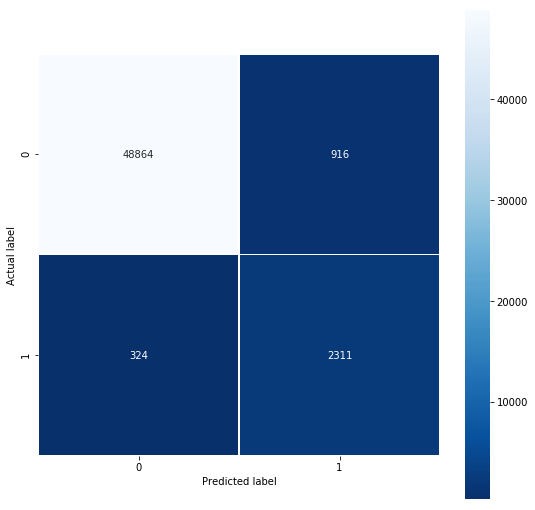

In [0]:
start = timer()

predict_with_confusion_matrix(**xgb_rand_only_klo.best_params_)

timer(start)

### Kloten basic unengineered features

In [0]:
feats_klo_exclusive = ['KLO_Air_temp','KLO_Hum','KLO_QNH','KLO_Wind_dir',	'KLO_Wind_max',	'KLO_Wind_speed']

In [0]:
start = timer()

xgb_rand_klo_exclusive =  train_test_modeling_no_score(df_base_train, df_base_test, feats_klo_exclusive, target_col, 2, **hyperparams)
                                    #(df_train, df_test, features, predicted_value, prediction=2, scoring="f1", **hyperparams):
timer(start)



{'tree_method': 'gpu_hist', 'subsample': 0.7, 'scale_pos_weight': 31.525974025974026, 'objective': 'binary:logistic', 'n_estimators': 110, 'max_depth': 8, 'gpu_id': 0, 'gamma': 5, 'eta': 0.05, 'colsample_bytree': 0.5}
0.9780060463170704
Test score: 0.9616903558141753

 Time taken: 0 hours 0 minutes and 30.77 seconds.


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     49780
           1       0.58      0.90      0.70      2635

    accuracy                           0.96     52415
   macro avg       0.79      0.93      0.84     52415
weighted avg       0.97      0.96      0.97     52415


 Time taken: 0 hours 0 minutes and 1.56 seconds.


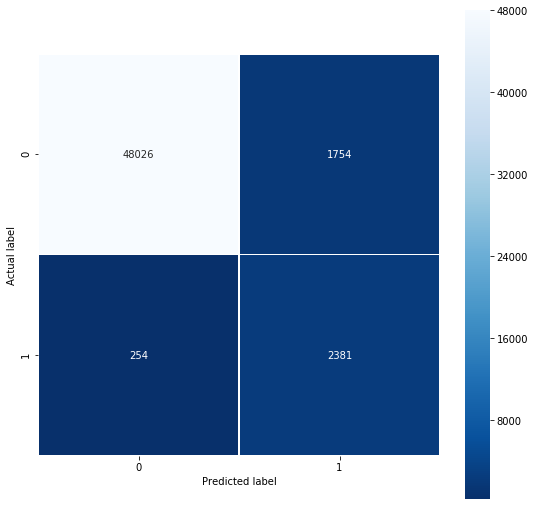

In [0]:
start = timer()


X_train = df_base_train[feats_klo_exclusive][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_klo_exclusive][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]
predict_with_confusion_matrix(**xgb_rand_klo_exclusive.best_params_)

timer(start)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.84      0.77      0.80      2635

    accuracy                           0.98     52415
   macro avg       0.92      0.88      0.90     52415
weighted avg       0.98      0.98      0.98     52415



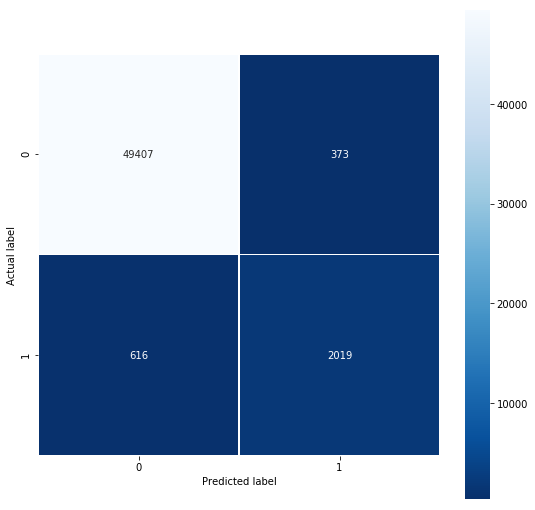

In [0]:
predict_with_confusion_matrix(**{})

### All 816 features

In [0]:
df_base_test.shape

(52417, 832)

In [0]:
feats_all = [c for c in df_base_test.columns if re.search('^[A-Z]{3}_', c)]
rest_cols = [c for c in df_base_test.columns if not(c in feats_all)]
print(len(feats_all), len(rest_cols))

816 16


816
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.86      0.80      0.83      2635

    accuracy                           0.98     52415
   macro avg       0.92      0.89      0.91     52415
weighted avg       0.98      0.98      0.98     52415



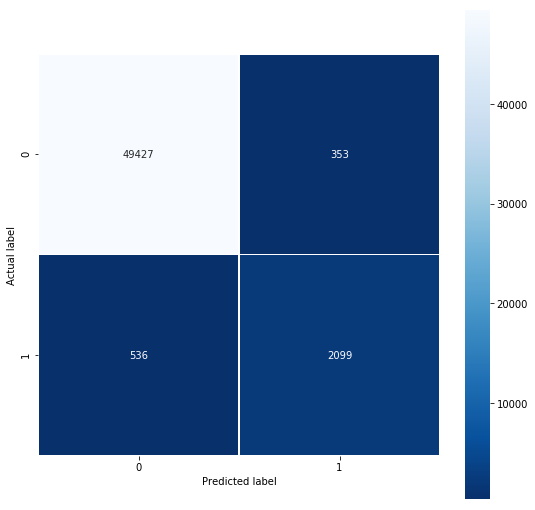

In [0]:
X_train = df_base_train[feats_all][:-prediction]  # everything except the 2 last values
y_train = df_base_train[target_col][prediction:]  # offset by 20mins
X_test = df_base_test[feats_all][:-prediction]  # everything except the 2 last values
y_test = df_base_test[target_col][prediction:]  # offset by 20mins

predict_with_confusion_matrix(**{})

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49782
           1       0.88      0.84      0.86      2635

    accuracy                           0.99     52417
   macro avg       0.93      0.92      0.93     52417
weighted avg       0.99      0.99      0.99     52417



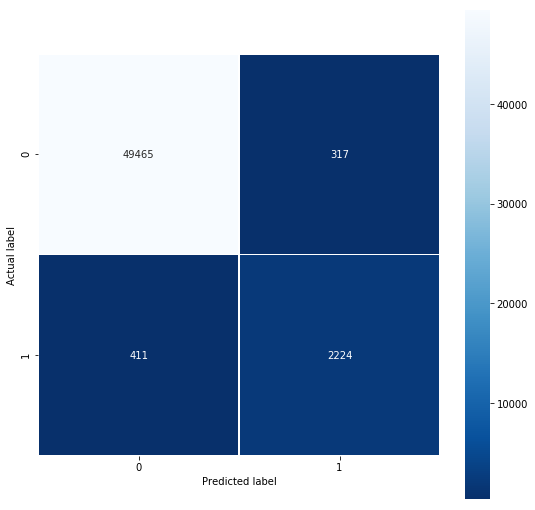

In [0]:
X_train = df_base_train[feats_all]  
y_train = df_base_train[target_col]  
X_test = df_base_test[feats_all]
y_test = df_base_test[target_col] 

predict_with_confusion_matrix(**{})

## Lagged predictions

In [0]:
df_base_train[feats].head()

,QNH_GUT_minus_PAY
6,-0.6
7,-0.4
8,-0.3
9,-0.3
10,-0.2


In [0]:
def run_xgboost_predictions_no_tuning1(df_train_x, df_train_y, df_test_x, df_test_y, longest_pred_period, dump_dir=None, **hyperparams):
    """Runs XGBoost with a fixed set of classifier hyperparameters, perfoming data delay to a maximum of 'longest_pred_period'
    steps (corresponding to 10 mins each)"""
    # initialise two empty dictionaries to store the models and scores
    xgboostmodels = {}
    xgboostscores = {}
    xgboostconfmatrixes = {}
    xgboostpredictions = {}
    prediction_period = [i for i in
                         range(1, longest_pred_period + 1)]  # how far into the future to predict (10 minute segments)

    score = -1
    counter = 1
    for prediction in prediction_period:

        reg = xgb.XGBClassifier()
        reg.set_params(**hyperparams)
        X_train = df_train_x[:-prediction]  # everything except the last value
        y_train = df_train_y[prediction:]  # offset by 10mins

        X_test = df_test_x[:-prediction]  # everything except the last value
        y_test = df_test_y[prediction:]  # offset by 10mins

        key = 'xgboost_model_' + str(prediction * 10)

        xgboostmodels[key] = reg.fit(X_train, y_train, verbose=2)  # store the model

        # score = np.mean(ms.cross_val_score(reg, x_train, y_train, scoring='roc_auc', cv=5))

        y_pred = reg.predict(X_test)
        xgboostpredictions[key] = y_pred

        prec_score, rec_score, f_score = get_scores(y_test, y_pred)
        xgboostscores[key] = prec_score  # store the model score

        print(classification_report(y_test, y_pred))
        print(counter, rec_score)
        if prec_score[1] > score:
            if dump_dir:
                file_path = join(dump_dir, 'xgb_no_tuning_' + str(time.time()) + '.dat')
                print(f'Model improved accuracy, saving to {file_path}')
                pickle.dump(reg, open(file_path, "wb"))
            score = prec_score[1]
        counter += 1

        cm = None
        try:
            cm = confusion_matrix(y_test, y_pred)
        except:
            print('Confusion Matrix crash!!!')
            print(type(y_test), type(y_pred))

        xgboostconfmatrixes[key] = cm
    return xgboostmodels, xgboostscores, xgboostconfmatrixes, xgboostpredictions 



In [0]:
xgboostmodels_2h, xgboostscores_2h, xgboostconfmatrixes_2h, xgboostpredictions_2h = run_xgboost_predictions_no_tuning1(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], steps_30_mins, None,**{})  

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49781
           1       0.87      0.82      0.85      2635

    accuracy                           0.99     52416
   macro avg       0.93      0.91      0.92     52416
weighted avg       0.98      0.99      0.98     52416

1 [0.99361202 0.82314991]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49780
           1       0.86      0.80      0.83      2635

    accuracy                           0.98     52415
   macro avg       0.92      0.89      0.91     52415
weighted avg       0.98      0.98      0.98     52415

2 [0.9929088  0.79658444]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49779
           1       0.85      0.77      0.81      2635

    accuracy                           0.98     52414
   macro avg       0.92      0.88      0.90     52414
weighted avg       0.9

In [0]:
print(xgboostscores_2h, xgboostconfmatrixes_2h, xgboostpredictions_2h)

{'xgboost_model_10': array([0.99066675, 0.8721351 ]), 'xgboost_model_20': array([0.98927206, 0.85603589]), 'xgboost_model_30': array([0.98782536, 0.84698997])} {'xgboost_model_10': array([[49463,   318],
       [  466,  2169]]), 'xgboost_model_20': array([[49427,   353],
       [  536,  2099]]), 'xgboost_model_30': array([[49413,   366],
       [  609,  2026]])} {'xgboost_model_10': array([0, 0, 0, ..., 0, 0, 0]), 'xgboost_model_20': array([0, 0, 0, ..., 0, 0, 0]), 'xgboost_model_30': array([0, 0, 0, ..., 0, 0, 0])}


In [0]:
df_res_30 = pd.DataFrame(columns=['Delay', 'TP', 'TN', 'FP', 'FN'])
df_res_30.head()

,Delay,TP,TN,FP,FN


In [0]:
tns = []
tps = []

for it in xgboostscores_2h.items():
  print(it)
  res= it[1]
  tns.append(res[0])
  tps.append(res[1])
df_res_30['Delay'] = [1, 2, 3]
df_res_30['TP'] = tps
df_res_30['TN'] = tns
df_res_30.head()

('xgboost_model_10', array([0.99066675, 0.8721351 ]))
('xgboost_model_20', array([0.98927206, 0.85603589]))
('xgboost_model_30', array([0.98782536, 0.84698997]))


,Delay,TP,TN,FP,FN
0,1,0.872135,0.990667,NaN,NaN
1,2,0.856036,0.989272,NaN,NaN
2,3,0.846990,0.987825,NaN,NaN


In [0]:
df_res_30.to_csv(join(data_path, 'delayed_results.csv'))

In [0]:
df_res_30.head()

,Delay,TP,TN,FP,FN
0,1,0.872135,0.990667,0.006067,0.008890
1,2,0.856036,0.989272,0.006734,0.010226
2,3,0.846990,0.987825,0.006982,0.011618


In [0]:
len(df_base_test)

52417

In [0]:
fps = []
fns = []
for it in xgboostconfmatrixes_2h.items():
  conf_tem = it[1]
  fps.append(conf_tem[0][1]/len(df_base_test))
  fns.append(conf_tem[1][0]/len(df_base_test))
  print(conf_tem)
  
print(fps, fns)

[[49463   318]
 [  466  2169]]
[[49427   353]
 [  536  2099]]
[[49413   366]
 [  609  2026]]
[0.006066734074823054, 0.006734456378655779, 0.006982467520079363] [0.00889024553103001, 0.010225690138695462, 0.011618368086689432]


In [0]:
df_res_30['FP'] = fps
df_res_30['FN'] = fns

In [0]:
def get_scores(y_test, y_pred):
    prec_score = precision_score(y_test.values, y_pred, average=None)
    #print('precision score: {:.6f}'.format(prec_score))

    rec_score = recall_score(y_test.values, y_pred, average=None)
    #print('recall score: {:.6f}'.format(rec_score))
    f_score = f1_score(y_test.values, y_pred, average=None)
    #print('f1 score: {:.6f}'.format(f_score))

    return prec_score, rec_score, f_score
  
def run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, pred_period=None, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification"""

    reg = xgb.XGBClassifier()
    reg.set_params(**hyperparams)
    
    X_train = df_train_x[:-pred_period]
    y_train = df_train_y[pred_period:]

    X_test = df_test_x[:-pred_period]
    y_test = df_test_y[pred_period:]

    reg.fit(X_train, y_train, verbose=2)

    y_pred = reg.predict(X_test)

    prec_score, rec_score, f_score = get_scores(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    if dump_dir:
        file_path = join(dump_dir, 'xgb_no_tuning_single_pred' + str(time.time()) + '.dat')
        print(f'saving to {file_path}')
        pickle.dump(reg, open(file_path, "wb"))

    cm = None

    try:
        cm = confusion_matrix(y_test, y_pred), y_pred
    except:
        print('Confusion Matrix crash!!!')
        print(type(y_test), type(y_pred))


    return reg, prec_score, rec_score, f_score, cm  
  

In [0]:
reg_40, prec_score_40, rec_score_40, f_score_40, cm_40 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], 4, dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49778
           1       0.83      0.75      0.79      2635

    accuracy                           0.98     52413
   macro avg       0.91      0.87      0.89     52413
weighted avg       0.98      0.98      0.98     52413



In [0]:
reg_50, prec_score_50, rec_score_50, f_score_50, cm_50 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], 5, dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49777
           1       0.82      0.73      0.77      2635

    accuracy                           0.98     52412
   macro avg       0.90      0.86      0.88     52412
weighted avg       0.98      0.98      0.98     52412



In [0]:
reg_60, prec_score_60, rec_score_60, f_score_60, cm_60 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], steps_1_hour, dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     49776
           1       0.82      0.70      0.76      2635

    accuracy                           0.98     52411
   macro avg       0.90      0.85      0.87     52411
weighted avg       0.98      0.98      0.98     52411



In [0]:
reg_120, prec_score_120, rec_score_120, f_score_120, cm_120 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], steps_12_hours, dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     49710
           1       0.69      0.19      0.30      2635

    accuracy                           0.95     52345
   macro avg       0.82      0.59      0.64     52345
weighted avg       0.95      0.95      0.94     52345



In [0]:
reg_70, prec_score_70, rec_score_70, f_score_70, cm_70 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], 7, dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     49775
           1       0.81      0.69      0.74      2635

    accuracy                           0.98     52410
   macro avg       0.90      0.84      0.86     52410
weighted avg       0.97      0.98      0.98     52410



In [0]:
cm_40

(array([[49384,   394],
        [  662,  1973]]), array([0, 0, 0, ..., 0, 0, 0]))

In [0]:
reg_80, prec_score_80, rec_score_80, f_score_80, cm_80 = run_xgboost_prediction(df_base_train[feats_all], df_base_train[target_col], df_base_test[feats_all], df_base_test[target_col], 8, dump_dir=None, **{})

In [0]:
reg, prec_score, rec_score, f_score, cm = run_xgboost_prediction_no_lag(df_base_train[feats], df_base_train[target_col], df_base_test[feats], df_base_test[target_col], dump_dir=None, **{})

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     49782
           1       0.68      0.19      0.30      2635

    accuracy                           0.95     52417
   macro avg       0.82      0.59      0.64     52417
weighted avg       0.94      0.95      0.94     52417



In [0]:
df_master

array([0.95869288, 0.68399453])

In [0]:
print(df_base_train.shape, df_base_test.shape)
df_base_train.head()

(210378, 832) (52417, 832)


,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_dir_spread30,BIZ_Wind_dir_spread60,BIZ_Wind_max_EW,BIZ_Wind_max_NS,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed_EW,BIZ_Wind_speed_NS,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_dir_spread30,BUS_Wind_dir_spread60,BUS_Wind_max_EW,BUS_Wind_max_NS,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed_EW,BUS_Wind_speed_NS,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_dir_spread30,GUT_Wind_dir_spread60,GUT_Wind_max_EW,GUT_Wind_max_NS,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed_EW,GUT_Wind_speed_NS,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_dir_spread30,KOP_Wind_dir_spread60,KOP_Wind_max_EW,KOP_Wind_max_NS,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed_EW,KOP_Wind_speed_NS,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_dir_spread30,MOA_Wind_dir_spread60,MOA_Wind_max_EW,MOA_Wind_max_NS,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed_EW,MOA_Wind_speed_NS,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_dir_spread30,MUB_Wind_dir_spread60,MUB_Wind_max_EW,MUB_Wind_max_NS,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed_EW,MUB_Wind_speed_NS,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_dir_spread30,PAY_Wind_dir_spread60,PAY_Wind_max_EW,PAY_Wind_max_NS,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed_EW,PAY_Wind_speed_NS,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_dir_spread30,PUY_Wind_dir_spread60,PUY_Wind_max_EW,PUY_Wind_max_NS,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed_EW,PUY_Wind_speed_NS,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_dir_spread30,REH_Wind_dir_spread60,REH_Wind_max_EW,REH_Wind_max_NS,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed_EW,REH_Wind_speed_NS,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_dir_spre

## Define target column and SMOTE upsample on it

Adding 'year' and 'month' to check on seasonal distribution

In [0]:
cols_target_and_features = ['rule4_duration_class', 'year', 'month'] + [c for c in df_master.columns if re.search('^[KLO]{3}_', c)]
len(cols_target_and_features)

24

In [0]:
target_col = 'rule4_duration_class'

In [0]:
df_unsampled_train_set = df_base_train[cols_target_and_features]

features = [c for c in cols_target_and_features if not(c == 'rule4_duration_class')]

X_train_rule4_dur_class = df_unsampled_train_set[features]
y_train_rule4_dur_class = df_unsampled_train_set.rule4_duration_class

print(X_train_rule4_dur_class.shape, y_train_rule4_dur_class.shape)
X_train_rule4_dur_class.head()

(140000, 23) (140000,)


,year,month,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6
6,2014,1,-2.5,89.8,-1.9,-6.3,1016.8,144.0,15.0,17.0,6.0,5.217492,4.428443,1.939691,-2.669756,3.3,-1.3,-2.3,1.351906,-1.860739,2.3,-1.4,-1.6
7,2014,1,-2.8,91.1,0.3,-4.1,1016.8,168.0,24.0,37.0,19.0,9.457507,5.678908,0.644526,-3.032258,3.1,-1.9,-2.6,0.457406,-2.151925,2.2,-1.9,-1.1
8,2014,1,-3.3,92.7,1.9,-1.7,1016.9,147.0,-21.0,18.0,2.0,11.747340,6.637436,1.361598,-2.096676,2.5,-2.3,-1.9,0.871422,-1.341873,1.6,-1.9,-1.5
9,2014,1,-2.9,89.8,0.0,-1.9,1016.9,151.0,4.0,7.0,24.0,10.713439,5.958188,1.357467,-2.448935,2.8,-0.5,-1.8,0.824176,-1.486854,1.7,-0.6,-2.0
10,2014,1,-2.7,90.4,-0.7,-0.4,1017.0,157.0,6.0,-11.0,26.0,7.401201,6.004628,1.484778,-3.497918,3.8,0.7,-1.2,0.859608,-2.025111,2.2,0.0,-1.9


In [0]:
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_rule4_dur_class==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_rule4_dur_class==1)))
print("Before OverSampling, counts of label '2': {} \n".format(sum(y_train_rule4_dur_class==2)))
print("Before OverSampling, counts of label '3': {} \n".format(sum(y_train_rule4_dur_class==3)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train_rule4_dur_class, y_train_rule4_dur_class.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {} \n".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))



Before OverSampling, counts of label '0': 135629 

Before OverSampling, counts of label '1': 1190
Before OverSampling, counts of label '2': 1832 

Before OverSampling, counts of label '3': 1349 

After OverSampling, the shape of train_X: (542516, 23)
After OverSampling, the shape of train_y: (542516,) 

After OverSampling, counts of label '0': 135629 

After OverSampling, counts of label '1': 135629
After OverSampling, counts of label '2': 135629 

After OverSampling, counts of label '3': 135629


In [0]:
df_train_sampled = pd.DataFrame(columns=features, data=X_train_res)

df_train_sampled.year = df_train_sampled.year.astype(int)
df_train_sampled.year.value_counts()

2015    245563
2014    204438
2016     92515
Name: year, dtype: int64

In [0]:
features_no_year = [f for f in features if not(f in ['rule4_duration_class', 'year', 'month'] ) ]
df_valid_x = df_base_valid[features_no_year]
df_valid_y = df_base_valid[target_col]
df_train_sampled = pd.DataFrame(columns=features_no_year, data=X_train_res[:, 2:])

In [0]:
features

['year',
 'month',
 'KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_dir_spread30',
 'KLO_Wind_dir_spread60',
 'KLO_Wind_max_EW',
 'KLO_Wind_max_NS',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed_EW',
 'KLO_Wind_speed_NS',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6']

In [0]:
hyperparams = {'subsample': 0.4, 'scale_pos_weight': 1, 'n_estimators': 50, 
               'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1,
              'objective': "multi:softprob", 'num_class': 4, 'eval_metric': 'mlogloss'}

reg_samp, prec_score_samp, rec_score_samp, f_score_samp, cm_samp = run_xgboost_prediction_no_lag(df_train_sampled, y_train_res, df_valid_x, df_valid_y, dump_dir=None, **hyperparams)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     68281
           1       0.15      0.67      0.25       564
           2       0.47      0.54      0.50       601
           3       0.80      0.65      0.72       932

    accuracy                           0.96     70378
   macro avg       0.60      0.71      0.61     70378
weighted avg       0.99      0.96      0.97     70378



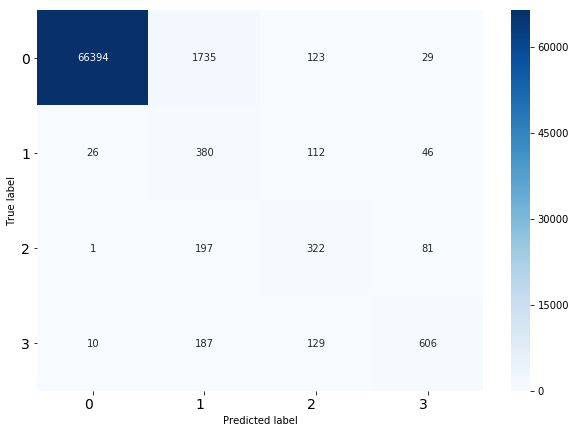

In [0]:
print_confusion_matrix(cm_samp[0], np.unique(y_train_rule4_dur_class))

In [0]:
reg, prec_score, rec_score, f_score, cm = run_xgboost_prediction_no_lag(X_train_rule4_dur_class[features_no_year], y_train_rule4_dur_class, df_valid_x, df_valid_y, dump_dir=None, **hyperparams)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     68281
           1       0.37      0.14      0.21       564
           2       0.50      0.61      0.55       601
           3       0.84      0.64      0.73       932

    accuracy                           0.98     70378
   macro avg       0.68      0.60      0.62     70378
weighted avg       0.98      0.98      0.98     70378



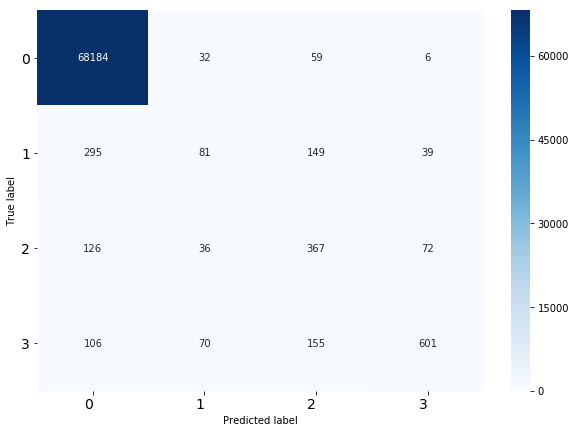

In [0]:
print_confusion_matrix(cm[0], np.unique(y_train_rule4_dur_class))

In [0]:
raw_features_klo = ['KLO_Air_temp','KLO_Hum','KLO_QNH','KLO_Wind_dir','KLO_Wind_max_EW','KLO_Wind_max_NS','KLO_Wind_speed_EW','KLO_Wind_speed_NS','KLO_Wind_speed']

In [0]:
reg_samp1, prec_score_samp1, rec_score_samp1, f_score_samp1, cm_samp1 = run_xgboost_prediction_no_lag(df_train_sampled[raw_features_klo], y_train_res, df_valid_x[raw_features_klo], df_valid_y, dump_dir=None, **hyperparams)



              precision    recall  f1-score   support

           0       1.00      0.97      0.98     68281
           1       0.13      0.63      0.21       564
           2       0.35      0.45      0.39       601
           3       0.72      0.52      0.61       932

    accuracy                           0.95     70378
   macro avg       0.55      0.64      0.55     70378
weighted avg       0.98      0.95      0.97     70378



In [0]:
df_train_sampled.shape

(542516, 21)